# Create CIGALE input files

Here we create the photometry files that we use as an input to [CIGALE](https://cigale.lam.fr/).  

All the code for create those files was develoved by [Andrés Ramos](a.f.ramos.padilla@rug.nl ).

In [1]:
from datetime import date
import time
import numpy as np
import astropy.units as u

from astroquery.ipac.ned import Ned
from astropy.table import Table, Column
from pathlib import Path

from matplotlib import pyplot as plt

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
Path(path_CIGALE_phot).mkdir(parents=True, exist_ok=True)
path_FINAL = '../Datos/Final/'
Path(path_FINAL).mkdir(parents=True, exist_ok=True)

date_sample = 'Apr_12_2022'
NeIR_obj_t = Table.read(path_raw+'Obj_Ne-IR_'+date_sample+'.vot',format='votable')
NeIR_obj_t.show_in_notebook()

idx,Main_Id,Id_used_NED,RA,DEC,otype_txt,redshift,rvz_type,otypes,cds_url,SMB_sample_index,Ne_IR_info,NED_Ne_IR_info
0,3C 234.0,3C 234.0,150.45634473807,28.7858176354,Sy1,0.18494,z,AGN|G |IR |QSO|Rad|Sy1|X |blu|gam,http://vizier.u-strasbg.fr/viz-bin/sed?-c=150.45634473807%2028.7858176354&-c.rs=5,283.0,NeII|NeIII|NeV,NeII|NeIII|NeV
1,M 84,M 84,186.2655972083333,12.886983138888887,Sy2,0.00327,z,* |AGN|G |GiC|GiG|IR |Rad|Sy2|UV |X |smm,http://vizier.u-strasbg.fr/viz-bin/sed?-c=186.2655972083333%2012.886983138888887&-c.rs=5,414.0,NeV,NeV
2,2MASS J13000535+1632148,NVSS J130005+163212,195.02228295163,16.53743305218,Sy1,0.07993,z,AGN|G |IR |Rad|Sy1|X,http://vizier.u-strasbg.fr/viz-bin/sed?-c=195.02228295163%2016.53743305218&-c.rs=5,428.0,NeII|NeIII,NeII|NeIII
3,NGC 262,NGC 262,12.196426138730002,31.956956641230004,Sy2,0.015260233939595302,v,* |AGN|Bla|G |GiG|IR |QSO|Rad|Sy2|X |gam,http://vizier.u-strasbg.fr/viz-bin/sed?-c=12.196426138730002%2031.956956641230004&-c.rs=5,484.0,NeII|NeIII|NeV,NeII|NeIII|NeV
4,IRAS 04385-0828,IRAS 04385-0828,70.2290037068,-8.37281297812,Sy2,0.015064,z,* |AGN|G |GiG|IR |Sy2,http://vizier.u-strasbg.fr/viz-bin/sed?-c=70.2290037068%20-8.37281297812&-c.rs=5,541.0,NeII|NeIII|NeV,NeII|NeIII|NeV
5,NGC 4945,NGC 4945,196.3636625,-49.4679,Sy2,0.0017968563040435814,v,AGN|G |GiG|IR |Rad|Sy2|X |cm |gam,http://vizier.u-strasbg.fr/viz-bin/sed?-c=196.3636625%20-49.4679&-c.rs=5,628.0,NeII|NeIII|NeV,NeII|NeIII|NeV
6,IC 4553,IC 4553,233.73843316666665,23.50322455555555,SyG,0.0184,z,AGN|G |GiG|GiP|IG |IR |LIN|Rad|SyG|X |gam|smm,http://vizier.u-strasbg.fr/viz-bin/sed?-c=233.73843316666665%2023.50322455555555&-c.rs=5,654.0,NeII|NeIII|NeV,NeII|NeIII|NeV
7,NGC 5252,NGC 5252,204.56612821846997,4.542644796,Sy2,0.02294,z,AG?|AGN|EmG|G |GiG|Sy1|Sy2|X |gam,http://vizier.u-strasbg.fr/viz-bin/sed?-c=204.56612821846997%204.542644796&-c.rs=5,773.0,NeII,NeII
8,Mrk 279,Mrk 279,208.26431206837998,69.30816969735,Sy1,0.030601,z,AGN|G |IR |QSO|Sy1|UV |X |gam,http://vizier.u-strasbg.fr/viz-bin/sed?-c=208.26431206837998%2069.30816969735&-c.rs=5,852.0,NeII|NeIII|NeV,NeII|NeIII|NeV
9,UGC 11680,UGC 11680,316.93375,3.875277777777778,Sy2,0.026,z,G |GiP|IG |IR |PaG|Sy2,http://vizier.u-strasbg.fr/viz-bin/sed?-c=316.93375%203.875277777777778&-c.rs=5,1227.0,NeII,NeII


### Create equivalences between NED and CDS tables
Here we create a list for the different names of the bands in NED and CDS. Each row represents the same band.

In [3]:
Equival = [['2-10 keV (XMM)', None, None],
           ['0.5-2 keV (XMM)', None, None],
           ['GALEX:FUV', 'FUV (GALEX)', None],
           ['GALEX:NUV', 'NUV (GALEX)', None],
           ["SDSS:u'", 'SDSS:u', 'u (SDSS) AB'],
           ["SDSS:g'", 'SDSS:g', 'g (SDSS) AB'],
           ["SDSS:r'", 'SDSS:r', 'r (SDSS) AB'],
           ["SDSS:i'", 'SDSS:i', 'i (SDSS) AB'],
           ["SDSS:z'", 'SDSS:z', 'z (SDSS) AB'],
           ['2MASS:J', 'J (2MASS) AB', None],
           ['2MASS:H', 'H (2MASS) AB', None],
           ['2MASS:Ks', 'Ks (2MASS) AB', None],
           ['WISE:W1', 'W1 (WISE)', None],
           [':=3.6um', '3.6 microns (IRAC)', None],
           [':=4.5um', '4.5 microns (IRAC)', None],
           ['WISE:W2', 'W2 (WISE)', None],
           [':=5.8um', '5.8 microns (IRAC)', None],
           [':=8um', '8.0 microns (IRAC)', None],
           ['IRAS:12', '12 microns (IRAS)', None],
           ['WISE:W3', 'W3 (WISE)', None],
           ['WISE:W4', 'W4 (WISE)', None],
           ['Spitzer/MIPS:24', '24 microns (MIPS)', None],
           ['IRAS:25', '25 microns (IRAS)', None],
           ['IRAS:60', '60 microns (IRAS)', None],
           ['Herschel/PACS:70', '70 microns (PACS)', None],
           ['Spitzer/MIPS:70', '70 microns (MIPS)', None],
           ['IRAS:100', '100 microns (IRAS)', None],
           ['Herschel/PACS:100', '100 microns (PACS)', None],
           ['Spitzer/MIPS:160', '160 microns (MIPS)', None],
           ['Herschel/PACS:160', '160 microns (PACS)', None],
           ['Herschel/SPIRE:250', '250 microns (SPIRE)', ':=250um'],
           ['Herschel/SPIRE:350', '350 microns (SPIRE)', ':=350um'],
           ['Herschel/SPIRE:500', '500 microns (SPIRE)', ':=500um'],
           [':=5GHz', ':=6cm', '4.89 GHz (VLA)'],
           [':=1.5GHz', ':=20cm', '1.46 GHz (VLA)'],
           [':=1.4GHz', ':=21cm', '1.4GHz']
           ]

### Transform photometry to CIGALE table

The next class allows us to transform the units of the SEDs in the selected bands.

In [4]:
class TransformCIGALE:
    """Class to plot the SEDs and create a row with the right units"""
    def __init__(self, sed):
        self.sed = sed
        #self.init_plot() # To check the SED
        self.create_row()

    def init_plot(self):
        "Plot the SED"
        plt.errorbar(self.sed['Wave'], self.sed['Flux'], yerr=self.sed['F_er'], fmt='o')
        plt.xlim(1e-6, 1e6)
        plt.loglog()

    def create_row(self):
        """Calculate the flux and error to use for the SED in CIGALE"""
        # Number of filtets/bands and their errors
        self.row = np.full(72, np.nan)
        iband = 0
        for band in Equival:
            crop = self.sed[np.logical_or.reduce([self.sed['Filter'] == band[0],
                                                  self.sed['Filter'] == band[1],
                                                  self.sed['Filter'] == band[2]])]
            flux = np.mean(crop['Flux'])
            std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)
            self.row[iband] = flux*1000  # To send in mJy
            self.row[iband+1] = std*1000  # To send in mJy
            iband += 2

We create a table with all the CIGALE bands/filters and fill it with the information that we get from NED and CDS. In some cases some of the galaxies are not useful because the bands are not found initially. This could take some minutes.

In [5]:
CIGALEFilter = ['xray_box_car_2to10keV', 'xray_box_car_0p5to2keV', 'FUV', 'NUV',
                'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'J_2mass',
                'H_2mass', 'Ks_2mass', 'WISE1', 'IRAC1', 'IRAC2', 'WISE2', 'IRAC3', 'IRAC4',
                'IRAS1', 'WISE3', 'WISE4', 'MIPS1', 'IRAS2', 'IRAS3', 'PACS_blue', 'MIPS2',
                'IRAS4', 'PACS_green', 'MIPS3', 'PACS_red', 'PSW_ext', 'PMW_ext', 'PLW_ext',
                'VLA_C', 'VLA_L', 'HI21cm']
# VLAC is 6cm ,VLAL is 20 cm and HI21cm is 1.4GHz
CIGFilt = [[filt, filt+'_err'] for filt in CIGALEFilter]
CIG = Table(names=np.array(CIGFilt).ravel())
GoodGalaxies = []

for igal, Galaxy in enumerate(NeIR_obj_t['Main_Id']):
    #     figure()
    try:
        sed_file = Table.read(path_SED+Galaxy + '_Phot.txt',
                          format='ascii')
        if len(sed_file) == 0:
            print(Galaxy, igal, 'No useful phot.')
        else:
            GoodGalaxies.append(igal)
            CIG.add_row(TransformCIGALE(sed_file).row)
    except FileNotFoundError:
        print(Galaxy, igal, 'No Phot. ERROR')

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_88333/2558554763.py:24: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)


In [6]:
print('Percentage of galaxies with X-ray data:',
      sum(~np.isnan(CIG[CIG.colnames[1]].data))/len(CIG))

Percentage of galaxies with X-ray data: 0.28133704735376047


In [7]:
print('Percentage of galaxies with VLA_C data:',
      sum(~np.isnan(CIG[CIG.colnames[67]].data))/len(CIG))

Percentage of galaxies with VLA_C data: 0.10027855153203342


In [8]:
print('Percentage of galaxies with VLA_L data:',
      sum(~np.isnan(CIG[CIG.colnames[69]].data))/len(CIG))

Percentage of galaxies with VLA_L data: 0.06963788300835655


In [9]:
CIG = CIG[CIG.colnames[4:-6]]  # Remove x-ray and radio wavelengths

We add the identifier (main_id) and the redshift from SIMBAD.

In [10]:
col_name = Column(name='id', data=NeIR_obj_t['Main_Id'][GoodGalaxies])
CIG.add_column(col_name, 0)
col_z = Column(name='redshift', data=NeIR_obj_t['redshift'][GoodGalaxies])
CIG.add_column(col_z, 1)

### Clean photometric values

Then, for each filter, we verify if the relative error is higher than 33%, in those cases we do not use that information for the modeling. In addition, we remove information with limits, that in some cases are annotated as negative values.

In [11]:
for igal in range(len(CIG)):
    for icol in CIG.colnames[2::2]:
        if CIG[icol+'_err'][igal]/CIG[icol][igal] >= 1/3.:  # Higher than 33%
            print(CIG['id'][igal], icol, CIG[icol+'_err'][igal]/CIG[icol][igal])
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan
        if CIG[icol+'_err'][igal]/CIG[icol][igal] <= 0:  # Negative Limits
            print('Negative', CIG['id'][igal], icol)
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan

3C 234.0 H_2mass 0.33998364516064733
M  84 J_2mass 0.7264293744836248
2MASS J13000535+1632148 FUV 0.4492512399613503
LEDA   45656 IRAS3 0.4358974358974359
LEDA   45656 IRAS4 0.33548387096774196
LEDA 3095998 H_2mass 0.3611261953891703
LEDA 3095998 Ks_2mass 0.4049506150848603
LEDA 3095998 WISE4 0.4394152443038262
LEDA 3095998 PSW_ext 0.4003778774826832
NGC  4477 IRAC3 20.779224522371056
NGC   185 z_prime 0.4017220356104894
NGC   185 Ks_2mass 0.5457768712330429
2MASS J00105486+0014510 FUV 0.4274428314030484
2MASS J00105486+0014510 u_prime 0.40307455336122244
2MASS J00105486+0014510 H_2mass 0.34446509995742075
Mrk  493 IRAS1 0.35659711704621994
2MASS J22255427+1958370 NUV 0.6543330714654052
2MASS J22255427+1958370 u_prime 0.5781937315181793
2MASS J22255427+1958370 H_2mass 0.3977961022174125
LEDA   90196 g_prime 0.6357300888648786
LEDA   90196 z_prime 0.7800115327801033
[VV2000] J235225.0+244009 u_prime 0.36755059183007355
[VV2000] J235225.0+244009 J_2mass 0.5108916263250483
[VV2000] J23522

LEDA  165630 Ks_2mass 0.42472553104006505
4C 23.43 J_2mass 0.389430877569179
4C 23.43 H_2mass 0.7727381134821321
4C 23.43 Ks_2mass 0.5755677657933852
4C 23.43 WISE4 0.42323876695806906
4C 23.43 MIPS2 0.4051695088543892
Mrk  705 IRAS4 0.3946774509549994
3C 286 H_2mass 0.44925181243203366
3C 286 PACS_green 0.7142857181561458
3C 286 PACS_red 0.6401138168954585
NGC  4725 IRAC4 0.34148498490289125
NGC  4725 WISE4 0.4212209890352737
[VV2003c] J124819.8+662143 FUV 0.36538699498827176
[VV2003c] J124819.8+662143 WISE4 0.3744481982311206
7C 1821+6419 u_prime 0.3458314580040222
Negative NGC  2110 NUV
NGC  2110 J_2mass 0.7243110804152233
2MASS J10514425+3539307 NUV 0.7120152535553957
SDSS J120424.54+192509.7 FUV 0.5841264625560284
NGC  4968 FUV 0.3422526119542966
NGC   253 i_prime 0.6012216765169461
NGC  3660 MIPS1 0.5
NGC  6926 r_prime 0.5292577183787163
NGC  6926 i_prime 0.34450865213008075
NGC  6926 z_prime 0.3380018714559641
2E  2389 MIPS3 0.48869047619047623
ESO 103-35 IRAS4 0.569766886545461

We define a minimum error for each filter to avoid overfitting

In [12]:
def add_min_err(phot_tab, list_bands, error):
    """Function to add a minimum error for the bands"""
    for col in list_bands:
        rel_error = phot_tab[col+'_err']/phot_tab[col]
        phot_tab[col+'_err'] = np.fmax(rel_error, error)*phot_tab[col]

In [13]:
add_min_err(CIG, ['FUV', 'NUV'], 0.1)
add_min_err(CIG, ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime'], 0.02)
add_min_err(CIG, ['J_2mass', 'H_2mass', 'Ks_2mass'], 0.02)
add_min_err(CIG, ['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4'], 0.03)
add_min_err(CIG, ['MIPS1', 'MIPS2', 'MIPS3'], 0.04)
add_min_err(CIG, ['WISE1', 'WISE2', 'WISE3', 'WISE4'], 0.06)
add_min_err(CIG, ['PACS_blue', 'PACS_green', 'PACS_red'], 0.1)
add_min_err(CIG, ['PSW_ext', 'PMW_ext', 'PLW_ext'], 0.07)

### Remove galaxies without energy balance

Then, we look for galaxies where the energy balance cannot be well constrained (i.e. galaxies where there is not enough bands in the optical and IR wavelengths).

In [14]:
BadGalaxies = []
for igal, Lrow in enumerate(CIG):
    IRPhotPoints = sum(~np.isnan(list(Lrow.as_void())[22:]))/2  # From WISE to PLW
    OpPhotPoints = sum(~np.isnan(list(Lrow.as_void())[2:22]))/2  # From FUV to Ks
    if IRPhotPoints < 3 or OpPhotPoints < 5:
         print('Galaxy %s has %i useful photometry points' %
               (Lrow['id'], IRPhotPoints+OpPhotPoints))
         BadGalaxies.append(igal)

Galaxy NGC  4945 has 15 useful photometry points
Galaxy UGC 11680 has 8 useful photometry points
Galaxy SWIFT J0624.1-6059 has 8 useful photometry points
Galaxy 2C 1066 has 11 useful photometry points
Galaxy 3C 343.1 has 7 useful photometry points
Galaxy IC 4518A has 14 useful photometry points
Galaxy NGC  4395 has 17 useful photometry points
Galaxy 3C  22.0 has 15 useful photometry points
Galaxy IRAS F00183-7111 has 14 useful photometry points
Galaxy [LGE2006] 12 has 12 useful photometry points


In [15]:
print('The total galaxies to remove is %d'%len(BadGalaxies))

The total galaxies to remove is 10


To complement this information we plot the total photometry points in the `BadGalaxies`.

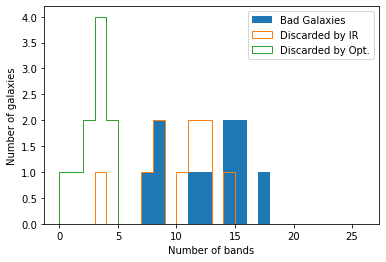

In [16]:
Tpins = []
TpinsIR = []
TpinsOp = []
for Lrow in CIG[BadGalaxies]:
    # All the bad galaxies
    Tpins.append(sum(~np.isnan(list(Lrow.as_void())[2:]))/2)
    # Galaxies discarded due to IR wavelegnths
    TpinsIR.append(sum(~np.isnan(list(Lrow.as_void())[22:]))/2)
    # Galaxies discarded due to Opt. wavelengths
    TpinsOp.append(sum(~np.isnan(list(Lrow.as_void())[2:22]))/2)
plt.hist(Tpins, bins=np.linspace(0, 26, 27), label='Bad Galaxies')
plt.hist(TpinsIR, bins=np.linspace(0, 26, 27),
         histtype='step', label='Discarded by IR')
plt.hist(TpinsOp, bins=np.linspace(0, 26, 27),
         histtype='step', label='Discarded by Opt.')
plt.ylabel('Number of galaxies')
plt.xlabel('Number of bands')
plt.legend()

Most of the `BadGalaxies` are located in a large range of redshifts, mainly affecting galaxies at redshifts above $z=0$. This means that some of these galaxies are not well covered in some of the selected instruments and/or that the photometric values are not well constrained.

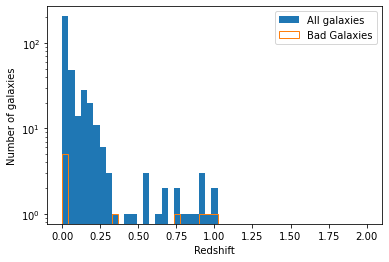

In [17]:
Redbins = np.linspace(0, 2, 50)
plt.hist(CIG['redshift'], bins=Redbins, label='All galaxies')
plt.hist(CIG[BadGalaxies]['redshift'], bins=Redbins, histtype='step', label='Bad Galaxies')
plt.xlabel('Redshift')
plt.ylabel('Number of galaxies')
plt.yscale('log')
plt.legend()

We save in a different file those galaxies that do not fulfill the energy balance we want. And then, we removed them from the sample.

In [18]:
CIG[BadGalaxies].write('../Datos/Complementary/CIGPhot_BadEnergyBalance.tbl', format='ascii',overwrite=True)

# Remove galaxies with bad energy balance coverage
CIG.remove_rows(BadGalaxies)

### Separating galaxies depending on redshift for the CIGALE photometry files

With this the sample of galaxies will have a range on redshifts of:

In [19]:
print("Min z=%.2f, Max z=%.2f and Median z~%.2f"%(
    np.min(CIG['redshift']),
    np.max(CIG['redshift']),
    np.median(CIG['redshift'])))

Min z=-0.00, Max z=0.99 and Median z~0.03


We found that most of our sample are below 𝑧=0.50, with a maximum at 𝑧=1, so we are going to split the galaxies in ten different groups/files to split the CIGALE runs and avoid computational overwork in CIGALE.

In [20]:
cnt, zbin = np.histogram(CIG['redshift'], bins=np.linspace(-0.01, 1.0, 100))
z_splits = np.percentile(zbin[:-1][cnt > 0], np.linspace(0, 100, 11))
z_splits[-1] += 0.01  # To add the last galaxy
group_zfile = np.digitize(CIG['redshift'], z_splits)

In [21]:
z_splits

array([-0.01      ,  0.03488889,  0.07977778,  0.12466667,  0.16955556,
        0.21444444,  0.26341414,  0.3960404 ,  0.6470101 ,  0.83064646,
        0.98959596])

Now we save the files for each group and count the number of galaxies per group.

In [22]:
csd = 0
for i in range(1, max(group_zfile)+1):
    csd += len(CIG[group_zfile == i])
    print('Group %i with %d galaxies' % (i, len(CIG[group_zfile == i])))
    CIG[group_zfile == i].write(path_CIGALE_phot+'CIGPhot_EnergyBal_'+str(i)+'.tbl',
                                format='ascii',overwrite=True)
assert len(CIG) == csd

Group 1 with 192 galaxies
Group 2 with 55 galaxies
Group 3 with 20 galaxies
Group 4 with 33 galaxies
Group 5 with 17 galaxies
Group 6 with 11 galaxies
Group 7 with 6 galaxies
Group 8 with 5 galaxies
Group 9 with 5 galaxies
Group 10 with 5 galaxies


We plot the distribution on redshift, with the bins defined for each final group.

Text(0, 0.5, 'Counts')

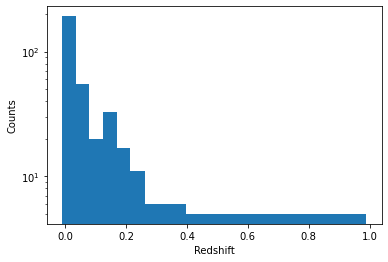

In [23]:
plt.hist(CIG['redshift'], bins=z_splits, log=True)
plt.xlabel('Redshift')
plt.ylabel('Counts')

Finally, we also save a file for all the galaxies, as in some cases this file is useful.

In [24]:
CIG.write(path_FINAL+'CIGPhot_EnergyBal_All.tbl', format='ascii',overwrite=True)

In [25]:
CIG

id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3C 234.0,0.18494,0.10159999801544473,0.015652477,0.07938000198919326,0.007938000198919326,0.12168760283278365,0.004588063170048556,0.19911266922463255,0.003982253384492651,0.46338666991990374,0.009870157999999999,0.5747533335428064,0.01403923,0.604496665497815,0.016634980329802016,2.0773333342125015,0.61318843,nan,nan,5.038461468827267,0.6604544,11.51666669199864,0.6910000015199184,14.700000000000001,0.441,25.4,0.7619999999999999,24.97916678947707,1.4987500073686242,42.7,1.2810000000000001,nan,nan,160.0,28.8,115.22500169277191,6.9135001015663144,289.92499858140945,17.395499914884567,274.5,10.98,258.0,35.2,231.0,36.900000000000006,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
M 84,0.00327,0.7200916729404949,0.1616562275281175,3.0804883431037724,0.7012790154585334,168.0749986730516,16.887911442660073,276.86499935186777,8.58330425911389,546.3376212349783,24.454584718653074,457.6099968398921,56.28791708861703,721.0112630273215,147.3731,nan,nan,1214.1266842683156,209.51718,763.1357269627707,168.03016000000002,457.67308149429465,32.201410809852725,412.5,80.67775406728666,175.06666666666666,46.30000003142013,304.27307501664524,28.8284003110999,111.39999999999999,28.400000794480626,105.875,19.01195749471895,178.12500163912776,43.31584441972735,44.0,2.6399999999999997,36.1,2.166,58.58750036656857,8.180516190215688,184.99999928474426,53.66192586742391,484.91666493813193,77.27167578899156,nan,nan,596.999993165334,47.39989549402087,1002.9166744152707,285.8325629105615,2390.0000351667404,411.0887763635612,586.833343664805,78.71308679278323,4257.249997138977,852.0699480349735,239.83333381017047,27.249816016755506,139.66666730244955,9.776666711171469,125.24999998509884,11.006361529497669
2MASS J13000535+1632148,0.07993,nan,nan,0.024666666528598096,0.005960704,0.21484999888343737,0.016248076889447016,0.8364499924937263,0.018411953325684707,2.232700002787169,0.08780091509073495,3.4850151430212217,0.06970030286042443,5.616999889025465,0.1123399977805093,4.738888832637006,0.6480741,7.277777754805154,1.1301769,11.521249893121421,1.1670904000000002,25.551666749812043,1.5331000049887225,nan,nan,nan,nan,41.49033305126552,2.489419983075931,nan,nan,nan,nan,nan,nan,90.7500009417534,5.4450000565052035,173.89583517362672,10.433750110417604,148.0,5.92,nan,nan,nan,nan,nan,nan,68.9999982714653,7.3999999999999995,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
NGC 262,0.015260233939595302,0.19701666860040276,0.019701666860040278,0.4016666728500277,0.040166667285002775,2.6366666425019503,0.05385164700000001,3.7700000684708357,0.15,7.50999990850687,0.1501999981701374,18.175000130819775,0.36350000261639553,27.443333878181875,0.5488666775636375,22.31999970972538,3.3421551,27.833333487311997,5.723635000000001,25.73846194606561,5.1643,55.02166668723027,3.301300001233816,47.00000040233135,2.8112497220986965,74.2,5.47,90.8333339681228,5.450000038087368,98.3,5.43,180.0,6.63

### Notebook info:

In [26]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.2.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.13.0-40-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.0

astropy   : 5.0
matplotlib: 3.5.0
numpy     : 1.20.3

Watermark: 2.3.0

